## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Classification Using Principal Component Data

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.stats as stat
import sklearn.preprocessing as pre
import glob
import mahotas as mt
import pywt
import seaborn as sns
import pandas as pd
import csv 
import matplotlib as mpl
import time

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from mlens.ensemble import SuperLearner
from mlens.metrics import make_scorer


%matplotlib inline


[MLENS] backend: threading


## Load data

In [2]:
train_df = pd.read_csv('Data/PCA_train_data.csv')
train = pd.DataFrame.as_matrix(train_df)
test = pd.DataFrame.as_matrix(pd.read_csv('Data/PCA_test_data.csv'))
train_data = train[:,2:]
label_train = train[:,1]
test_data = test[:,2:]
label_test = test[:,1]
components = list(train_df.columns[2:]) 
print(np.shape(train_data))
print(np.shape(test_data))
n_ALL = 7272
n_hem = 3389
components

(10661, 6)
(1867, 6)


/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

# Classification

In [3]:
def get_errors(prediction, label):
    """
    args:
        label: numpy array of ground truth (1 is positive, 0 is negative)
        prediction: numpy array of prediction
    returns:
        false_positive: integer of occurences of false positives
        false_negative: integer of occurences of false negatives
        true_positive: integer of occurences of true positives
        true_negative: integer of occurences of true negatives
    """
    diff = label - prediction
    false_positive = np.count_nonzero(diff == -1)
    false_negative = np.count_nonzero(diff == 1)
    total_positive = np.sum(label)
    total_negative = int(len(label) - total_positive)
    true_positive = int(total_positive - false_negative)
    true_negative = total_negative - false_positive
    print('True Positive:  ',true_positive)
    print('False Positive: ',false_positive)
    print('True Negative:  ',true_negative)
    print('False Negative: ',false_negative)
    print('Accuracy:       ', np.round((true_positive + true_negative) / 
                                       (total_positive + total_negative), decimals=3))

## Support Vector Machine (SVM)

In [6]:
# SVM
# Tuning the hyperparameters
param_grid =  {'C': [1], 'gamma': [5,7,10], 'kernel': ['rbf'], 'probability':[True]}
SV_clf = GridSearchCV(svm.SVC(), param_grid, cv=5)
t0 = time.time()
SV_clf.fit(train_data, label_train)
svc_fit = time.time() - t0
print("SVM gamma and C selected and model fitted in %.2f s"
      % svc_fit)


# save the best hyperparameters
svm_c, svm_gamma = SV_clf.best_estimator_.C, SV_clf.best_estimator_.gamma

print('best score:', SV_clf.best_score_)                               
print('best C value:', svm_c)
print('best gamma value:', svm_gamma)

SVM gamma and C selected and model fitted in 119.53 s
best score: 0.8229997186005065
best C value: 1
best gamma value: 7


In [7]:
# see how it works on the training data
print('SVM Results')
print('-------------------------')
print('Training Data:')
train_predictions = SV_clf.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = SV_clf.predict(test_data)
get_errors(test_predictions, label_test)

SVM Results
-------------------------
Training Data:
True Positive:   6943
False Positive:  1235
True Negative:   2154
False Negative:  329
Accuracy:        0.853
 
Test Data:
True Positive:   1161
False Positive:  452
True Negative:   196
False Negative:  58
Accuracy:        0.727


## Random Forest (RF)

In [8]:
# more conservative rf
rf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=75, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# fit
rf2.fit(train_data, label_train)


# see how it works on the training data
print('RF Results')
print('-------------------------')
print('Training Data:')
train_predictions = rf2.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = rf2.predict(test_data)
get_errors(test_predictions, label_test)

RF Results
-------------------------
Training Data:
True Positive:   7183
False Positive:  519
True Negative:   2870
False Negative:  89
Accuracy:        0.943
 
Test Data:
True Positive:   1133
False Positive:  437
True Negative:   211
False Negative:  86
Accuracy:        0.72


## K Nearest Neighbors

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [10]:
"""
Find best K values using cross validation
"""
def k_fold_test(train_data, train_label, train_index, test_index, k_value):
    KNN = KNeighborsClassifier(n_neighbors = k_value, weights="uniform", algorithm="brute") 
    KNN.fit(train_data[train_index,:], train_label[train_index])
    mean_accuracy_current_fold = KNN.score(train_data[test_index,:], train_label[test_index])
    return mean_accuracy_current_fold

def k_value_use_k_fold(train_data, train_label, k_value, kfold_nsplit):
    all_mean_accuracy = []
    kf = KFold(n_splits = kfold_nsplit, shuffle = False)
    for train_index, test_index in kf.split(train_data):
        mean_accuracy_current_fold = k_fold_test(train_data, train_label, train_index, test_index, k_value)
        all_mean_accuracy.append(mean_accuracy_current_fold)
    average_accuracy = np.round(np.mean(np.array(all_mean_accuracy)), decimals=4)
    print("{} \t {}".format(k_value, average_accuracy))
    return average_accuracy

In [11]:
"""
Actual Testing
"""
number_of_splits = 10
k_value_list = [4,6,8,9,10, 30, 50, 90, 100, 150, 200]
test_tuple_list = []
print('K val \t Avg. Accuracy')
print('--------------------------')
for k_value in k_value_list:
    average_accuracy = k_value_use_k_fold(train_data, label_train, k_value, number_of_splits)
    test_tuple_list.append((average_accuracy, k_value))
test_tuple_list.sort(reverse = True)
best_k_value = test_tuple_list[0][1]

K val 	 Avg. Accuracy
--------------------------
4 	 0.7315
6 	 0.7588
8 	 0.7719
9 	 0.7847
10 	 0.7773
30 	 0.7833
50 	 0.7788
90 	 0.7726
100 	 0.7733
150 	 0.7671
200 	 0.7659


In [12]:
# Use the best K_value

print("Best K Value is {}".format(best_k_value))
print(' ')
KNN_clf = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")


# train and predict
KNN_clf.fit(train_data, label_train)
KNN_train_pred = KNN_clf.predict(train_data)
KNN_test_pred = KNN_clf.predict(test_data)


# print results
# train results
print('KNN Results')
print('-------------------------')
print('Training Data')
get_errors(KNN_train_pred, label_train)

# test results
print(' ')
print('Test Data')
get_errors(KNN_test_pred, label_test)

Best K Value is 9
 
KNN Results
-------------------------
Training Data
True Positive:   6860
False Positive:  1102
True Negative:   2287
False Negative:  412
Accuracy:        0.858
 
Test Data
True Positive:   1142
False Positive:  458
True Negative:   190
False Negative:  77
Accuracy:        0.713


## Ensemble

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#import xgboost as xgb
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

seed = 2034
np.random.seed(seed)

In [14]:
# Max Voting
# create models with the optomizal hyperparameters from above
svc = svm.SVC(C=svm_c, gamma=svm_gamma, kernel='rbf', probability=True)
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
knn = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")
ests = [('svc', svc), ('rf', rf), ('knn', knn)]

# create the max-vote classifier
MV_clf = VotingClassifier(estimators=ests, voting='soft')

# train and predict
MV_clf.fit(train_data, label_train)
mv_train_pred = MV_clf.predict(train_data)
mv_test_pred = MV_clf.predict(test_data)


# print results
# train results
print('Max Voting Results')
print('-------------------------')
print('Train Data')
get_errors(mv_train_pred, label_train)

# test results
print(' ')
print('Test Data')
get_errors(mv_test_pred, label_test)

Max Voting Results
-------------------------
Train Data
True Positive:   7083
False Positive:  884
True Negative:   2505
False Negative:  189
Accuracy:        0.899
 
Test Data
True Positive:   1146
False Positive:  449
True Negative:   199
False Negative:  73
Accuracy:        0.72


### ROC Curve

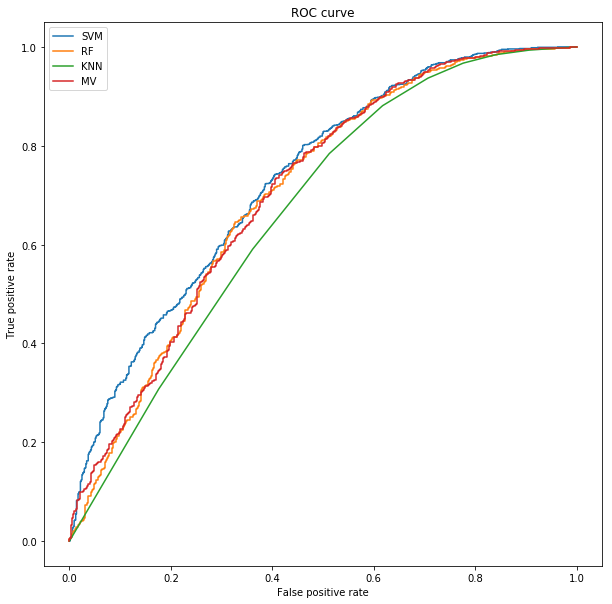

In [16]:
from sklearn.metrics import roc_curve
SVM_prob = SV_clf.predict_proba(test_data)[:,1]
FPR_SVM, TPR_SVM, _ = roc_curve(label_test, SVM_prob)
RF_prob = rf2.predict_proba(test_data)[:,1]
FPR_RF, TPR_RF, _ = roc_curve(label_test, RF_prob)
KNN_prob = KNN_clf.predict_proba(test_data)[:,1]
FPR_KNN, TPR_KNN, _ = roc_curve(label_test, KNN_prob)
MV_prob = MV_clf.predict_proba(test_data)[:,1]
FPR_MV, TPR_MV, _ = roc_curve(label_test, MV_prob)



plt.figure(1, figsize = (10,10))
plt.plot(FPR_SVM, TPR_SVM, label='SVM')
plt.plot(FPR_RF, TPR_RF, label='RF')
plt.plot(FPR_KNN, TPR_KNN, label='KNN')
plt.plot(FPR_MV, TPR_MV, label='MV')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()